<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*VQE algorithm: Application to quantum chemistry*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q Experience (QX), consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Antonio Mezzacapo, Jay Gambetta, others

### Introduction

One of the earliest and most compelling applications of quantum computation is the idea of using quantum computers to simulate other quantum systems. Quantum simulation encompasses a range of tasks, including most significantly 
    
1. simulation of the time evolution of quantum systems
2. computation of thermal or ground state properties. 

These tasks are useful for applications such as quantum chemistry and in the simulation of properties of strongly correlated materials. Here we will focus on the second one.  These states encode a lot of the information about the physical system of interest, and are highly relevant for understanding the properties of materials and complex molecules. The ground state is the starting point for mapping out the phase diagram of condensed matter Hamiltonians and encodes the central information of electronic structure problems in quantum Chemistry. The problem asks the following:

For some physical Hamiltonian *H*, (approximately) prepare the eigenstate $|\psi_G\rangle$, i.e. $H|\psi_G\rangle=E_G|\psi_G\rangle$, where $E_G$ is the smallest eigenvalue of $H$.
    
It is known that in general this problem is intractable even on a quantum computer. This means that we cannot expect an efficient quantum algorithm which prepares the ground state of general local Hamiltonians. Despite this limitation, for a specific Hamiltonian of interest it might be possible to exploit special structure to solve the above problem efficiently. Currently, (at least) four different methods exist to approach this problem. 

1. Quantum phase estimation: Here we assume that we can approximately prepare the state $|\psi_G\rangle$ and then this routine is used to give the eigenvalue. 
2. Adiabatic theorem of quantum mechanics. Here we assume that the system can be moved from an easy prepared ground state adiabtically to the harder state. 
3. Variational quantum eigensolver. Here we assume that ground state can be represented by a prameterization containing a small (e.g., polynomial) number of parameters.
4. Dissipative (non-unitary) quantum operation which has the ground state as a fixed point. Here we assume that we can design this dissiapation map. 

Here we are interested in the third method as this is most likely the simplest to be realized on near term devices. 

The general idea is to define a paremeterization $|\psi(\theta)\rangle$ and minimize the energy 

$$E(\theta) = \langle \psi(\theta)| H |\psi(\theta)\rangle,$$ 

Assumption 1. The set of controls $\theta^*$ that minimizes this objective funtion has a size $|\theta|$ that ploynomial in number of qubits.  

For any Hamiltoian (and shown below) this can be rewritten as a sum over pauli operations  

$$H = \sum_i^M w_i P_i,$$ 

then E(\theta) can be estimated by sampling 

$$E(\theta) = \sum_i^M w_i \langle \psi(\theta)| P_i |\psi(\theta)\rangle,$$ 

Assumption 2. The number of terms to be estimated is polynomial in the number of qubits. In the most general case $M=4^n$ but for physical interesting Hamiltonians like chemisty M = N^4 where N is the number of orbitals.



### Fermi Hamiltonian

Some comments about how to get a Fermi Hamiltonian


### Molecules considered

H2, LiH, BeH2, Water

### Approximate Universal Quantum Computing for quantum chemisty problems

Recently there has been interest in investgating approximate algorithims for optimization [ADD REFS]. Here we show a slight variation to them which we have been looking at under the general concept of approximate quantum computing.  In general we dont expect this to have a expodential speed up but due to the nature and importance of these problems it is worth investigating Heuristic approaches on a quantum computer. The hope is that that due to the large space of a quantum computer we can explore the problem by exploiting entanglement to trade expodential calls for quantum depth. 

The Algorithm works as follows:
1. Choose a Ising problem (can have higher powers of Z).
2. Choose the maximum depth of the quantum circuit (this could be done adaptively.
3. Choos a set of controls $\theta$ and make a trial function $|\psi(\theta)\rangle$.
4. Evaluate $C = \langle\psi~|H|~\psi\rangle = \sum_i w_i \langle\psi~|Z_i|~\psi\rangle+ \sum_{i<j} w_{ij} \langle\psi~|Z_iZ_j|~\psi\rangle$ by sampling the outcome of the circuit and adding the expectation values together.
5. Use a classical optimizer to choose a new set of controls.
6. Continue until the C has reach a minimium and return $|\langle z~|\psi\rangle|^2$.
    

Not some benifits on this over making this is real hardware is we are not limited to the connectivity of the device and it is trival to map optimize problems to the virtual Hamiltonain which we make though simulation. Getting higher orders such as $Z_iZ_jZ_k$ is simple which in real hardware is generally possible. The noise is mainly due to the gates and if the depth is small enough we can perform this high fidelity.

It is our belief the difficult of finding good Heuristic algorithms will come down ot the trial funciton. Do we choose a trial function that has entanglement in a way that best aligns with the problem (as indicated in [REF]). or do we make the amount of entanglement a variable [REF]. These questions are beyond our goals here and we will consider only the simplie trial functions 

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a function of cPhase gates (fully entangling), and $U_\mathrm{single}(\theta) = Z(\theta_2)Y(\theta_1)^{\otimes n}$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of states that have only real superpostions and dont have to worry about refocusing out all the complex phases but still can exploit the entanglment to search for solutions.


In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la


import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig
import math

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_ryrz,trial_circuit_ry, SPSA_optimization
from tools.optimizationtools import Energy_Estimate, Measure_pauli_z, Hamiltonian_from_file, make_Hamiltonian
from functools import partial
from tools.pauli import Pauli, label_to_pauli
from tools.chemical_tools import fermionic_maps 



In [5]:
fermionic_maps(0,0,'Parity',0)
4 % 3
#ggg=Pauli([1],[0])
#print(ggg.to_label())

XXXXX
YXXXX
ZXXXX
IYXXX
IZXXX
IIYXX
IIZXX
IIIYX
IIIZX
IIIIY


1

In [1]:
def eval_hamiltonian(n,m,file_name,device,shots,H,theta):


    file = open(file_name, 'r+')
    ham_array = file.readlines()
    ham_array = [x.strip() for x in ham_array]
    for i in range(len(ham_array)//2):
        string = ham_array[2*i]        
    
    avg_energy=0
    var_energy=0
    std_energy=0
    
    
    
    
    Q_program = QuantumProgram()
    Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])
    
    
    # STACK QUANTUM CIRCUITS ASSOCIATED TO EACH PAULI TERM AND EXECUTE THEM 
    
    if shots!=1:
        
        circuits=[]
        trial_circuit=[]
        
        for i in range(len(ham_array)//2):     

            trial_circuit.append(trial_circuit_ryrz(n,m,theta,entangler_map,ham_array[i*2],True))
            circuits.append("trial_circuit_label"+str(i))
            Q_program.add_circuit(circuits[i],trial_circuit[i])


        # EXECUTE THE CIRCUITS STACKED 

        Q_program.execute(circuits,device,shots)
    
    
    
        pauli_list=Hamiltonian_from_file(file_name)

        for i in range(len(ham_array)//2):#loop over Pauli terms

            pauli_avg=Energy_Estimate(Q_program.get_counts("trial_circuit_label"+str(i)),pauli_list[i])
            avg_energy+=pauli_avg
    
    else:
    
        circuit=['circuit']
        Q_program.add_circuit(circuit[0],trial_circuit_ryrz(n,m,theta,entangler_map,None,False))
        Q_program.execute(circuit,device,shots)
        avg_energy=(np.inner(np.conjugate(Q_program.get_data(circuit[0])['quantum_state']),np.dot(H,Q_program.get_data(circuit[0])['quantum_state']))).real
        
    
    return avg_energy,std_energy
                        

In [8]:
p=(Pauli((1,0),(0,1)),3)
g=Pauli([1,1,1],[1,0,0])
d=Pauli([1],[0])
np.append(  np.zeros((1,4)),    np.ones((1,3)))
p[0]


## Optimization of H2 at bond length

In [1]:
n=2
m=2
device='ibmqx2'
SPSA_params=[1,.1,.602,.101,0]
theta=np.zeros(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=35
ham_name='H2/H2Equilibrium.txt'

#Exact Energy
pauli_list=Hamiltonian_from_file(ham_name)
H=make_Hamiltonian(pauli_list)
exact=np.amin(la.eig(H)[0]).real
        
# Optimization
eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,ham_name,device,shots,H)
eval_hamiltonian_partial(theta)

output=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials,1);
plt.plot(output[2],label='E(theta_plus)')
plt.plot(output[3],label='E(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Energy')
plt.plot(np.ones(max_trials)*exact,label='Exact Energy')
plt.legend()
plt.xlabel('Trial state')
plt.ylabel('Energy')

NameError: name 'np' is not defined

## Optimizing the potential energy surface 

/Users/amezzac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part



OPTIMIZING HAMILTONIAN # 0 AT INTERATOMIC DISTANCE 0.2 ANGSTROM

Energy at theta+ for step # 0
-0.299266100503
Energy at theta- for step # 0
-0.668947848803
Energy at theta+ for step # 5
-0.679674188641
Energy at theta- for step # 5
-0.709632797659
Final Energy is: -0.938968870822

OPTIMIZING HAMILTONIAN # 1 AT INTERATOMIC DISTANCE 0.3 ANGSTROM

Energy at theta+ for step # 0
-0.600098525685
Energy at theta- for step # 0
-0.595476158079
Energy at theta+ for step # 5
-1.42215089781
Energy at theta- for step # 5
-1.3375910446
Final Energy is: -1.7253357309

OPTIMIZING HAMILTONIAN # 2 AT INTERATOMIC DISTANCE 0.4 ANGSTROM

Energy at theta+ for step # 0
-0.839652410355
Energy at theta- for step # 0
-0.565947972016
Energy at theta+ for step # 5
-1.60288009758
Energy at theta- for step # 5
-1.69666258511
Final Energy is: -2.05463747843

OPTIMIZING HAMILTONIAN # 3 AT INTERATOMIC DISTANCE 0.5 ANGSTROM

Energy at theta+ for step # 0
-0.787256189596
Energy at theta- for step # 0
-0.787256189596
E

Energy at theta+ for step # 0
-0.510441315125
Energy at theta- for step # 0
-0.506742443482
Energy at theta+ for step # 5
-0.522046162727
Energy at theta- for step # 5
-0.537998870013
Final Energy is: -0.588648282096

OPTIMIZING HAMILTONIAN # 30 AT INTERATOMIC DISTANCE 3.2 ANGSTROM

Energy at theta+ for step # 0
-0.504040419924
Energy at theta- for step # 0
-0.504040419924
Energy at theta+ for step # 5
-0.499256441878
Energy at theta- for step # 5
-0.492786004431
Final Energy is: -0.509945495085

OPTIMIZING HAMILTONIAN # 31 AT INTERATOMIC DISTANCE 3.3 ANGSTROM

Energy at theta+ for step # 0
-0.487644405306
Energy at theta- for step # 0
-0.488851310128
Energy at theta+ for step # 5
-0.484793057554
Energy at theta- for step # 5
-0.488119278527
Final Energy is: -0.482091547004

OPTIMIZING HAMILTONIAN # 32 AT INTERATOMIC DISTANCE 3.4 ANGSTROM

Energy at theta+ for step # 0
-0.47893515265
Energy at theta- for step # 0
-0.47893515265
Energy at theta+ for step # 5
-0.475877323601
Energy at th

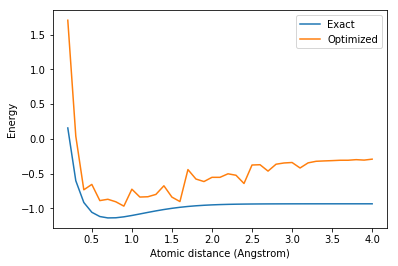

In [4]:
# MOLECULE PARAMETERS

molecule='H2' #name of the molecule: options are H2 or LiH

if molecule=='H2':
    n=2 # qubits
    Z1=1
    Z2=1
    min_distance=.2
    max_distance=4
    number_of_points=39
elif molecule=='LiH':
    n=4 # qubits
    Z1=1
    Z2=3
    min_distance=.5
    max_distance=5
    number_of_points=46
    
    
# OPTIMIZATION PARAMETERS 

run_optimization='Yes' # Choose 'Yes' or 'No'

m=2 # depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
theta=np.zeros(2*n*m)  # initial angles 
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=10
SPSA_params=[1,.1,.602,.101,0]



####################     COMPUTING FOR THE POTENTIAL ENERGY SURFACE      ###################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)
electr_energy_optimized=np.zeros(number_of_points)

for i in range(number_of_points):

    
    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance[i]=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        
        distance=mol_distance[i]/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance[i])+'.txt'
        pauli_list=Hamiltonian_from_file(ham_text)
        H=make_Hamiltonian(pauli_list)
        eigen=la.eig(H)
        electr_energy[i]=np.amin(eigen[0])
        
        
        
    # optimization
    
        if run_optimization=='Yes':
            print('\nOPTIMIZING HAMILTONIAN # '+str(i)+' AT INTERATOMIC DISTANCE '+str(mol_distance[i])+' ANGSTROM\n')
            eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,ham_text,device,shots,H)
            electr_energy_optimized[i]=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials,5)[0]
            


plt.plot(mol_distance,electr_energy+coulomb_repulsion,label='Exact')
plt.plot(mol_distance,electr_energy_optimized+coulomb_repulsion,label='Optimized') 
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
        